In [2]:
#pip install spotipy
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline, set_seed
from Levenshtein import distance

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_2 = pd.read_csv('spotify_dataset.csv', on_bad_lines='skip')
df_2

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
12891619,2302bf9c64dc63d88a750215ed187f2c,Mötley Crüe,Wild Side,iPhone
12891620,2302bf9c64dc63d88a750215ed187f2c,John Lennon,Woman,iPhone
12891621,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Don't Know How It Feels,iPhone
12891622,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Wreck Me,iPhone


In [4]:
df = df_2.copy()
df.isnull().sum()

user_id          0
artistname       0
trackname        0
playlistname    46
dtype: int64

In [5]:
df.columns = df.columns.str.replace("\"", "")
df.columns

Index(['user_id', 'artistname', 'trackname', 'playlistname'], dtype='object')

In [6]:
df["artistname"] = df["artistname"].fillna(df["artistname"].mode()[0])
df["trackname"] = df["trackname"].fillna(df["trackname"].mode()[0])
df["playlistname"] = df["playlistname"].fillna(df["playlistname"].mode()[0])
df['playlistname'] = df['playlistname'].str.strip()
df

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
12891619,2302bf9c64dc63d88a750215ed187f2c,Mötley Crüe,Wild Side,iPhone
12891620,2302bf9c64dc63d88a750215ed187f2c,John Lennon,Woman,iPhone
12891621,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Don't Know How It Feels,iPhone
12891622,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Wreck Me,iPhone


## Exploratory Data Analysis

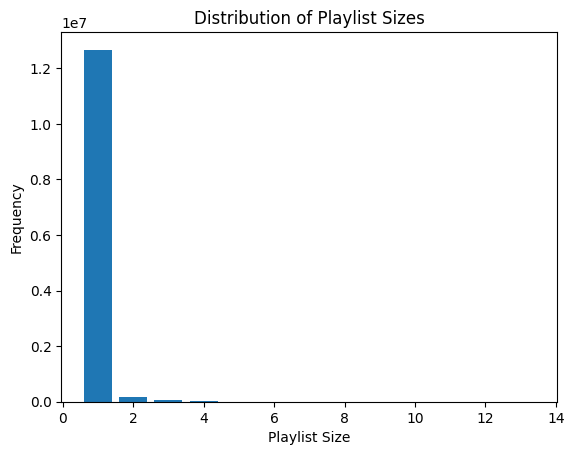

In [7]:
# Distribution of Playlist Sizes
import seaborn as sns
import matplotlib.pyplot as plt

playlist_size = df['playlistname'].apply(lambda x: len(x.split(',')))
plt.bar(playlist_size.value_counts().index, playlist_size.value_counts().values)
plt.xlabel('Playlist Size')
plt.ylabel('Frequency')
plt.title('Distribution of Playlist Sizes')
plt.show()

Majority of playlist sizes are 1, so most portion of playlists consist of single tracks

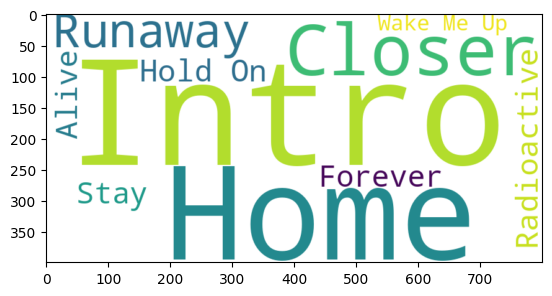

In [8]:
top_n_tracks = df['trackname'].astype(str).value_counts().head(10)
from wordcloud import WordCloud
wordcloud_data = dict(zip(top_n_tracks.index, top_n_tracks.values))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)
plt.imshow(wordcloud, interpolation='bilinear')

## Feature Engineering and User-Item Matrix Conversion

In [9]:
segmented_df = df.copy()
segmented_df

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
12891619,2302bf9c64dc63d88a750215ed187f2c,Mötley Crüe,Wild Side,iPhone
12891620,2302bf9c64dc63d88a750215ed187f2c,John Lennon,Woman,iPhone
12891621,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Don't Know How It Feels,iPhone
12891622,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Wreck Me,iPhone


In [10]:

segmented_df[['user_id', 'playlistname']].value_counts()

user_id                           playlistname                                          
4398de6902abde3351347b048fcdc287  Starred                                                   47362
68756b4d60b6fac27789e85c2b63d1c6  Starred                                                   18510
c410ee930bd5f0e4893632503ec17b05  Starred                                                   18084
f2604a69836c94d00fcd11dd602944fc  everything                                                15824
6b85a8076b4f3b1036ef15f09e2feeeb  Generos                                                   14877
                                                                                            ...  
77fb6aaef631f798992c0e3c341f4376  Happy hardcore                                                1
                                  Drum & Bass                                                   1
b2aa73946de806f318a4931dc6ded72d  Riptide - FlicFlac Edit                                       1
ed7e04b3ac6e8e9bcc87215dc3d84

In [11]:
segmented_df[(segmented_df['user_id'] == '4398de6902abde3351347b048fcdc287') & (segmented_df['playlistname'] == 'Starred')]

,user_id,artistname,trackname,playlistname
6639902,4398de6902abde3351347b048fcdc287,The Gaslight Anthem,"45""""",Starred
6639903,4398de6902abde3351347b048fcdc287,Rebekka Karijord,"I´ve Always Been Jealous of Migratory Birds""""",Starred
6639904,4398de6902abde3351347b048fcdc287,Mutual Benefit,"Let's Play"" / Statue of a Man""",Starred
6639905,4398de6902abde3351347b048fcdc287,Lucius,"Turn It Around""- Spotify Sessions Curated by J...",Starred
6639906,4398de6902abde3351347b048fcdc287,Shakey Graves,"Unlucky Skin"" - Live from Spotify Nyc""",Starred
...,...,...,...,...
6687259,4398de6902abde3351347b048fcdc287,Raised By Swans,Öxnadalur,Starred
6687260,4398de6902abde3351347b048fcdc287,Victor Villarreal,“That Familiar Band” Song,Starred
6687261,4398de6902abde3351347b048fcdc287,Ryan Hemsworth,「Every Square Inch」 - With Qrion,Starred
6687262,4398de6902abde3351347b048fcdc287,Joy Wellboy,﻿Lay Down Your Blade,Starred


In [12]:
# Groupby to generate user item matrix
def group_users(df):
    df = df.drop_duplicates(subset=['user_id', 'playlistname'])
    df['click_count'] = 1
    user_item_matrix = df.groupby(['user_id', 'trackname'])['click_count'].sum().reset_index()

    return user_item_matrix


In [13]:
user_item_matrix = group_users(segmented_df)

/var/folders/3t/t58dnlt54s5cdr1hhtxqb5hr0000gn/T/ipykernel_8327/2273858435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['click_count'] = 1


In [14]:
user_item_matrix

,user_id,trackname,click_count
0,00055176fea33f6e027cd3302289378b,18,1
1,0007f3dd09c91198371454c608d47f22,(Everything I Do) I Do It For You,1
2,0007f3dd09c91198371454c608d47f22,2014,1
3,0007f3dd09c91198371454c608d47f22,Hurt,1
4,000b0f32b5739f052b9d40fcc5c41079,A Blessed Christmas Eve,1
...,...,...,...
223428,fff616055993498d6127f3f467cf9f2b,All About It (feat. Ed Sheeran),1
223429,fff616055993498d6127f3f467cf9f2b,All Jacked Up,1
223430,fff616055993498d6127f3f467cf9f2b,Animal (Billboard Remix),1
223431,fff616055993498d6127f3f467cf9f2b,Cinema,1


In [15]:
# generate similarity matrix using topic similarity
def generate_similarity_matrix(df):
    numeric_user_item_matrix = df.pivot_table(index='user_id', columns='trackname', values='click_count', fill_value=0)
    sparse_user_item_matrix = csr_matrix(numeric_user_item_matrix)
    similarity_matrix = cosine_similarity(sparse_user_item_matrix.T)
    track_similarity_df = pd.DataFrame(similarity_matrix, index=numeric_user_item_matrix.columns, columns=numeric_user_item_matrix.columns)
    return track_similarity_df

In [16]:
track_similarity_df = generate_similarity_matrix(user_item_matrix)

In [17]:
track_similarity_df

trackname,""" (Acoustical ) by Everclear""",15 Years of Tummy Touch Records in Dub,Da,Daedelus - Looking Ocean Ep,"Dios Te Bendiga """"",Episode 22,History O,"Jewel "" Taking Refuge In The Three Jewels""",New Wave,"R.I.P """"",...,他夏了夏天 - Live,凡人的告白書,可愛女人,嘻嘻哈哈過新年,憨阿嬤,虚無の終わり 箱詰めの黙示,虹の彼方 (Kneeeeee Remix),꽃,﻿Before The Sunrise,🐯🐯🐯🐯
trackname,,,,,,,,,,,,,,,,,,,,,
""" (Acoustical ) by Everclear""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15 Years of Tummy Touch Records in Dub,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Da,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Daedelus - Looking Ocean Ep,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Dios Te Bendiga """"",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
虚無の終わり 箱詰めの黙示,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
虹の彼方 (Kneeeeee Remix),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
꽃,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [18]:
track_similarity_df.columns

Index(['            "  (Acoustical ) by Everclear"',
       ' 15 Years of Tummy Touch Records in Dub', ' Da',
       ' Daedelus - Looking Ocean Ep', ' Dios Te Bendiga ""', ' Episode 22',
       ' History O', ' Jewel " Taking Refuge In The Three Jewels"',
       ' New Wave', ' R.I.P ""',
       ...
       '他夏了夏天 - Live', '凡人的告白書', '可愛女人', '嘻嘻哈哈過新年', '憨阿嬤', '虚無の終わり 箱詰めの黙示',
       '虹の彼方 (Kneeeeee Remix)', '꽃', '﻿Before The Sunrise', '🐯🐯🐯🐯'],
      dtype='object', name='trackname', length=78499)

In [19]:
track_similarity_df.index.name = None
track_similarity_df

,""" (Acoustical ) by Everclear""",15 Years of Tummy Touch Records in Dub,Da,Daedelus - Looking Ocean Ep,"Dios Te Bendiga """"",Episode 22,History O,"Jewel "" Taking Refuge In The Three Jewels""",New Wave,"R.I.P """"",...,他夏了夏天 - Live,凡人的告白書,可愛女人,嘻嘻哈哈過新年,憨阿嬤,虚無の終わり 箱詰めの黙示,虹の彼方 (Kneeeeee Remix),꽃,﻿Before The Sunrise,🐯🐯🐯🐯
""" (Acoustical ) by Everclear""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15 Years of Tummy Touch Records in Dub,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Da,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Daedelus - Looking Ocean Ep,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Dios Te Bendiga """"",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
虚無の終わり 箱詰めの黙示,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
虹の彼方 (Kneeeeee Remix),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
꽃,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
﻿Before The Sunrise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
# get the recommendation
def get_recommendations(df, song):
    recommendations = df[song].sort_values(ascending=False)[1:2]
    top_recommendation = recommendations.index.item()
    return top_recommendation

In [21]:
recommendations = get_recommendations(track_similarity_df, ' New Wave')
recommendations

'African Sleigh Ride'

## LLM Song Descriptions

In [22]:
def generate_raw_descriptions(song):
    generator = pipeline('text-generation', 'gpt2')
    set_seed(42)
    output = generator(song, max_length=30, num_return_sequences=5, top_k=50)
    return output

In [23]:
output= generate_raw_descriptions(recommendations)
output

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'African Sleigh Ride" at the U.N. headquarters in Nairobi.\n\nA police officer\'s body camera video also shows police officers'},
 {'generated_text': 'African Sleigh Ride and in December 2012, he and three other men were arrested following a fight over the use of a stun gun in San Francisco,'},
 {'generated_text': 'African Sleigh Ride," has already been sold out of town. The group\'s new single, "Stay with Me," was released at a new venue'},
 {'generated_text': 'African Sleigh Ride was the third installment of the Star Wars movie trilogy after Battle of the Bastards, as well as the first of the Return of'},
 {'generated_text': 'African Sleigh Ride is set to arrive in November and will be produced by Chris Anderson, who also wrote The Last Ship, an animated feature about a'}]

In [24]:
# generate sentiment scores
def generate_sent_scores(output):
    sentiment_analyzer = pipeline("sentiment-analysis")
    sequence_scores = []
    for sequence in output:
        sentiment_score = sentiment_analyzer(sequence['generated_text'])[0]["score"]
        total_score = sentiment_score
        sequence_scores.append([sequence['generated_text'], total_score])
        sequence_scores.sort(key=lambda x: x[1], reverse=True)
    return sequence_scores

In [25]:
sequence_scores = generate_sent_scores(output)
sequence_scores

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[['African Sleigh Ride was the third installment of the Star Wars movie trilogy after Battle of the Bastards, as well as the first of the Return of',
  0.9957129955291748],
 ['African Sleigh Ride is set to arrive in November and will be produced by Chris Anderson, who also wrote The Last Ship, an animated feature about a',
  0.9942215085029602],
 ['African Sleigh Ride" at the U.N. headquarters in Nairobi.\n\nA police officer\'s body camera video also shows police officers',
  0.981939971446991],
 ['African Sleigh Ride and in December 2012, he and three other men were arrested following a fight over the use of a stun gun in San Francisco,',
  0.980771005153656],
 ['African Sleigh Ride," has already been sold out of town. The group\'s new single, "Stay with Me," was released at a new venue',
  0.7325963377952576]]

In [26]:
# generate levenshtein scores
def generate_dissimilarity_scores(output):
    scores = []
    for val in range(len(output)):
        for val_2 in range(1, len(output)):
            score = distance(output[val]['generated_text'], output[val_2]['generated_text'])
            scores.append([output[val]['generated_text'], output[val_2]['generated_text'], score])
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores        
dissimilarity_scores = generate_dissimilarity_scores(output)
dissimilarity_scores

[['African Sleigh Ride and in December 2012, he and three other men were arrested following a fight over the use of a stun gun in San Francisco,',
  'African Sleigh Ride is set to arrive in November and will be produced by Chris Anderson, who also wrote The Last Ship, an animated feature about a',
  100],
 ['African Sleigh Ride is set to arrive in November and will be produced by Chris Anderson, who also wrote The Last Ship, an animated feature about a',
  'African Sleigh Ride and in December 2012, he and three other men were arrested following a fight over the use of a stun gun in San Francisco,',
  100],
 ['African Sleigh Ride" at the U.N. headquarters in Nairobi.\n\nA police officer\'s body camera video also shows police officers',
  'African Sleigh Ride is set to arrive in November and will be produced by Chris Anderson, who also wrote The Last Ship, an animated feature about a',
  99],
 ['African Sleigh Ride and in December 2012, he and three other men were arrested following a fi

In [27]:
# combine sentiment and levenshtein scores and get final recommendation
def get_song_description(sent_scores, dissimilarity_scores):
    sentiment_weight, levenshtein_weight = 0.7, 0.3
    combined_scores = []
    for sentiment_entry, levenshtein_entry in zip(sent_scores, dissimilarity_scores):
        sentiment_sentence, sentiment_score = sentiment_entry
        levenshtein_sent_1, levenshtein_sent_2, levenshtein_score = levenshtein_entry

        # Normalize sentiment score (assuming sentiment score is in the range [0, 1])
        normalized_sentiment_score = sentiment_score

        # Combine scores using weighted average
        combined_score = (sentiment_weight * normalized_sentiment_score) + (levenshtein_weight * levenshtein_score)

        # Store the combined score along with the sequences
        combined_scores.append([sentiment_sentence, levenshtein_sent_1, levenshtein_sent_2, combined_score])

    # Sort the combined scores based on the combined score
    sorted_combined_scores = sorted(combined_scores, key=lambda x: x[3], reverse=True)
    top_sequence = sorted_combined_scores[0]

    print("Top Sequence:", top_sequence)
    return top_sequence


In [28]:
recommended_song_description = get_song_description(sequence_scores, dissimilarity_scores)

Top Sequence: ['African Sleigh Ride was the third installment of the Star Wars movie trilogy after Battle of the Bastards, as well as the first of the Return of', 'African Sleigh Ride and in December 2012, he and three other men were arrested following a fight over the use of a stun gun in San Francisco,', 'African Sleigh Ride is set to arrive in November and will be produced by Chris Anderson, who also wrote The Last Ship, an animated feature about a', 30.69699909687042]


In [29]:
# Get the final output with collaborative filtering recommendations, song description, and combined score

output = {
    'collaborative_filtering_recommendations': recommendations,
    'Song Description': recommended_song_description[0],
    'Combined Score': recommended_song_description[3]
}

In [30]:
output

{'collaborative_filtering_recommendations': 'African Sleigh Ride',
 'Song Description': 'African Sleigh Ride was the third installment of the Star Wars movie trilogy after Battle of the Bastards, as well as the first of the Return of',
 'Combined Score': 30.69699909687042}

In [31]:
len(track_similarity_df)

78499

In [32]:
78499 / 2

39249.5

## A/B Hypothesis Testing

Null Hypothesis: There is no significant difference betwee versions A and B

Alternative Hypothesis: There is a significant difference between versions A and B

In [38]:
import numpy as np

hypothesis_df = user_item_matrix.sample(n=1000)
hypothesis_df['version'] = np.random.choice(['A', 'B'], size=len(hypothesis_df))
hypothesis_df

,user_id,trackname,click_count,version
133358,9711a19adb72df4874eb071a4a650697,A Jaunt To Hawaii,1,B
1708,020b7c51047d473927d3f0b4437793be,#99,1,B
119320,872a19d491f4357408551be6d7eea273,Autumn Eyes,1,B
164319,bbe0800f9d92567c537cdb12e1a830cc,Hero (feat. Josey Scott),1,A
116117,833fb1aaf579d4ed1b8a51cf3629ccbd,Beyond The Darkness,1,B
...,...,...,...,...
72679,51a9f50b52ceca1123ce035e699989c0,1234,1,A
176338,ca41e34478977929ba86e70022a66be3,2 On,1,B
4868,05a353f3c328c3c28ef9440e38facf8c,Communication - 2005 Remastered Version,1,B
173747,c7014736594309b971278d48931aefbd,A Medio Camino - Live,1,B


In [39]:
group_a_data = hypothesis_df[hypothesis_df['version'] == 'A']
group_b_data = hypothesis_df[hypothesis_df['version'] == 'A']

In [40]:
from scipy.stats import ttest_ind

t_test = p_value = ttest_ind(group_a_data['click_count'], group_b_data['click_count'])

In [41]:
p_value

TtestResult(statistic=0.0, pvalue=1.0, df=1012.0)